In [1]:
from lib.controller import Controller
from lib.automation import FileDetector
from lib.file.TIF import TIFArrayFile
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
import time
import os
import pickle
from lib.utilities import *

In [26]:
dir_base = "C:/Users/jjudge3/Desktop/Data/"
date = "07-19-22"
data_dir = dir_base + date +"/"
camera_program = 4

slice_target = 1
rec_target = [i for i in range(5,18)]

load_dic = False
num_regions_to_export = 5  # max number of regions per record to export to PhotoZ
process_all = False  # overrides slice/rec target to process all files

time_course_types = ['Max', 'Avg']
time_course_choice = 0  # index

# recording schedule
int_trial = 10
num_trial = 5
int_recording = 45
tbs_recording_no = 8
actual_int_recording = int_trial * num_trial + int_recording

#cluster settings
k_cluster = 60  # set to None for AIC elbow plotting
# cluster filter settings
n_pixel_cutoff = 3  # maximum cluster size allowed
average_snr_cutoff_percentile = 50  # cluster-specific percentile

# save time loading and clustering data by loading a saved run
restore_pickle = None  # saved run index or None. Will find higher index to avoid overwrite
save_pickle_index = 0

In [3]:
# read in 8-bit single TIF images to array, apply same cropping/binning
single_images = {}

if load_dic and restore_pickle is None:
    dic_dir = data_dir + "dic/"

    cam_settings = CameraSettings().get_program_settings(camera_program)
    binning = int(cam_settings['height'] / 80)

    for filename in os.listdir(dic_dir):
        if filename.endswith(".tif"):

            tif = TIFArrayFile(filename, dic_dir, cam_settings, binning,
                              show_image=(str(slice_target) in filename and
                                          'e' in filename))

            img = tif.get_data()
            meta = tif.get_meta()
            slic = meta['slice_number']
            loc = meta['location_number']
            img_type = meta['img_type']

            if slic not in single_images:
                single_images[slic] = {}
            if loc not in single_images[slic]:
                single_images[slic][loc] = {}

            single_images[slic][loc][img_type] = img

01_01_01.zda
01_01_02.zda
01_01_03.zda
01_01_04.zda
01_01_05.zda
01_01_06.zda
01_01_07.zda
01_01_08.zda
01_01_09.zda
01_01_10.zda
01_01_11.zda
01_01_12.zda
01_01_13.zda
01_01_14.zda
01_01_15.zda
01_01_16.zda
01_01_17.zda
SNR01_01_01.dat
SNR01_01_02.dat
SNR01_01_03.dat
SNR01_01_04.dat
SNR01_01_05.dat
SNR01_01_06.dat
SNR01_01_07.dat
SNR01_01_08.dat
SNR01_01_09.dat
SNR01_01_10.dat
SNR01_01_11.dat
SNR01_01_12.dat
SNR01_01_13.dat
SNR01_01_14.dat
SNR01_01_15.dat
SNR01_01_16.dat
SNR01_01_17.dat


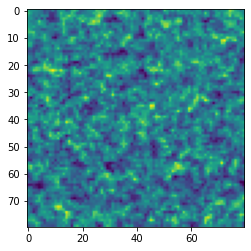

In [4]:
# read in non-normalized maps exported from PhotoZ: 
#  pre-stim SNR, stim SNR, and stim MaxAmp (DAT files)
dat_dir = data_dir + "converted_zda/"
if restore_pickle is None:
    for filename in os.listdir(dat_dir):
        print(filename)
        if filename.endswith(".dat") and filename[:3] != "ROI":
            map_type = filename[:3]
            name_parse = filename.split('.')[0][-8:]
            try:
                slic, loc, rec = [int(x) for x in name_parse.split('_')]
            except ValueError:
                continue
            if slic not in single_images:
                single_images[slic] = {}
            if loc not in single_images[slic]:
                single_images[slic][loc] = {}
            if map_type not in single_images[slic][loc]:
                single_images[slic][loc][map_type] = {}
            dat = np.loadtxt(dat_dir + filename,
                             delimiter='\t',
                             usecols=(1,))
            width = int(np.sqrt(dat.shape[0]))
            dat = dat.reshape((width, width))
            if map_type == "SNR" and slic == slice_target and rec in rec_target:
                plt.imshow(dat)
            single_images[slic][loc][map_type][rec] = {
                'data': dat,
                'filename': filename}

In [5]:
# record stim amplitudes manually

# for 06-21-22
"""
single_images[1][1]['stims'] = [100, 100, 100, 80, 80, 60, 60, 40, 40]
single_images[2][1]['stims'] = [40, 100, 100, 80, 80, 60, 60]
single_images[3][1]['stims'] = [100, 100, 80, 80, 60, 60]
"""

# for 07-12-22
#single_images[1][1]['stims'] = [80, 60, 60, 50, 40] + [40 for _ in range(6, 24)]
print(single_images)

{1: {1: {'SNR': {1: {'data': array([[0.277686, 0.292396, 0.273943, ..., 0.458581, 0.465187, 0.431761],
       [0.326155, 0.453799, 0.357568, ..., 0.5103  , 0.373395, 0.537507],
       [0.530892, 0.545286, 0.429116, ..., 0.565887, 0.441864, 0.497119],
       ...,
       [0.099778, 0.204849, 0.272586, ..., 0.564774, 0.533046, 0.57433 ],
       [0.394474, 0.306369, 0.401369, ..., 0.572249, 0.541821, 0.503085],
       [0.481604, 0.598435, 0.345603, ..., 0.451552, 0.492201, 0.501252]]), 'filename': 'SNR01_01_01.dat'}, 2: {'data': array([[0.457277 , 0.167337 , 0.139056 , ..., 0.43518  , 0.563968 ,
        0.60311  ],
       [0.341911 , 0.165683 , 0.0725172, ..., 0.425273 , 0.606984 ,
        0.687299 ],
       [0.382662 , 0.185565 , 0.197767 , ..., 0.465629 , 0.515581 ,
        0.521957 ],
       ...,
       [0.323501 , 0.522045 , 0.470711 , ..., 0.507451 , 0.573522 ,
        0.522021 ],
       [0.390465 , 0.449312 , 0.561786 , ..., 0.438239 , 0.448446 ,
        0.48362  ],
       [0.387789 

In [6]:
roi = ROI_Identifier()

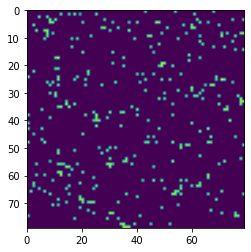

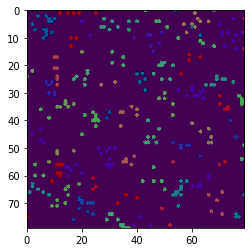

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs85-SNR01_01_01.dat


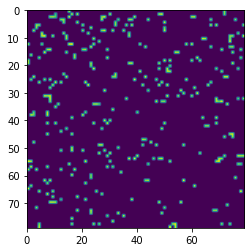

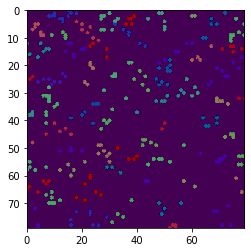

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs90-SNR01_01_01.dat


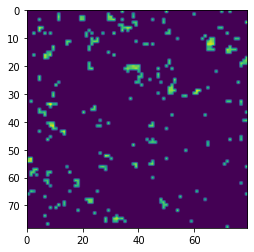

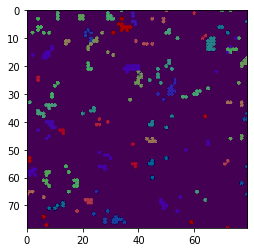

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs95-SNR01_01_01.dat


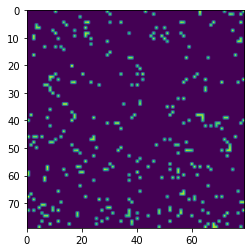

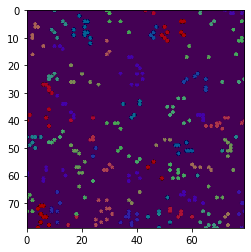

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs85-SNR01_01_02.dat


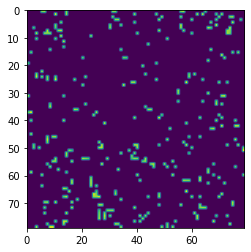

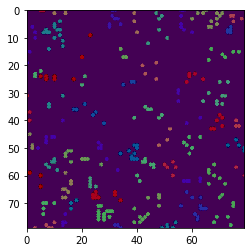

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs90-SNR01_01_02.dat


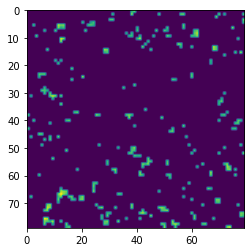

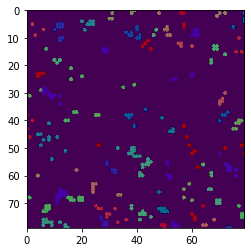

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs95-SNR01_01_02.dat


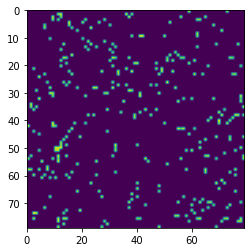

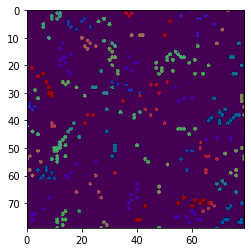

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs85-SNR01_01_03.dat


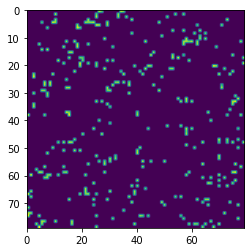

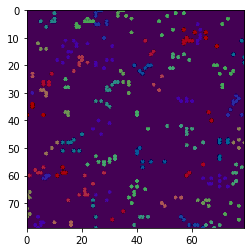

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs90-SNR01_01_03.dat


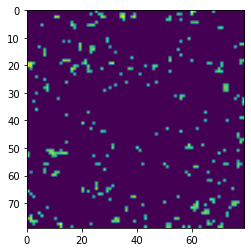

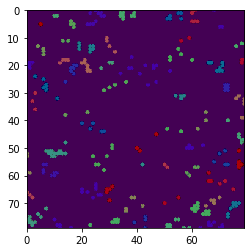

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs95-SNR01_01_03.dat


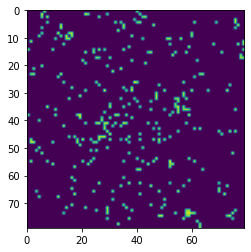

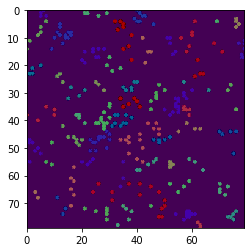

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs85-SNR01_01_04.dat


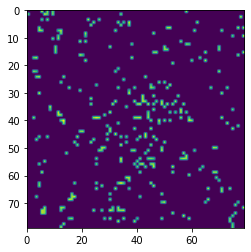

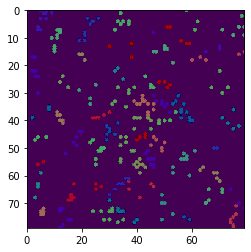

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs90-SNR01_01_04.dat


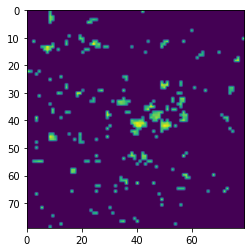

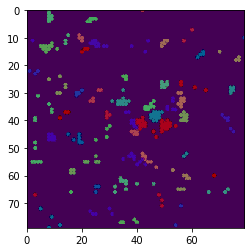

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs95-SNR01_01_04.dat


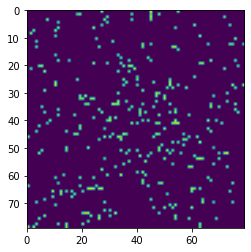

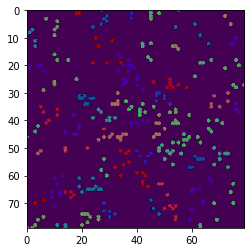

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs85-SNR01_01_05.dat


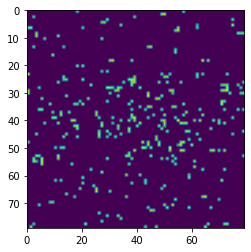

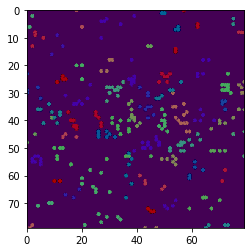

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs90-SNR01_01_05.dat


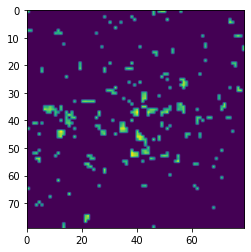

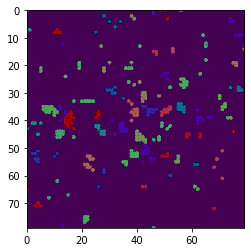

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs95-SNR01_01_05.dat


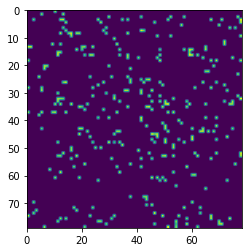

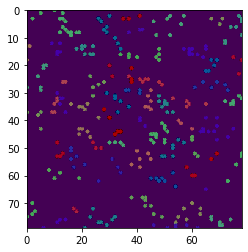

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs85-SNR01_01_06.dat


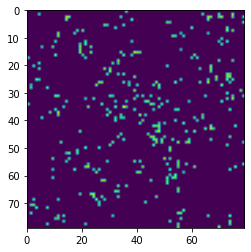

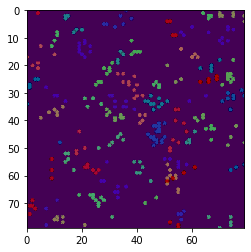

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs90-SNR01_01_06.dat


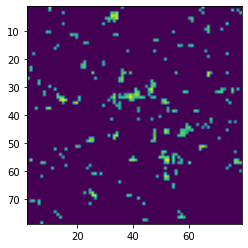

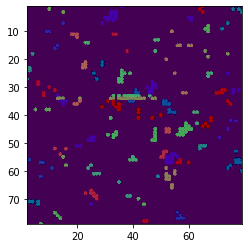

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs95-SNR01_01_06.dat


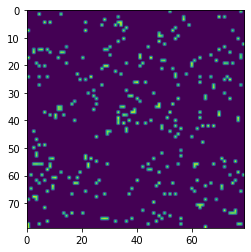

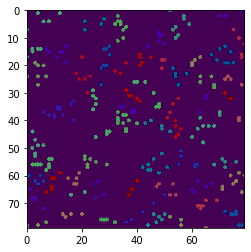

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs85-SNR01_01_07.dat


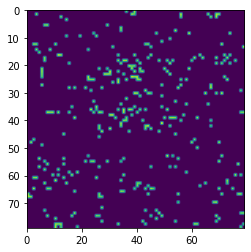

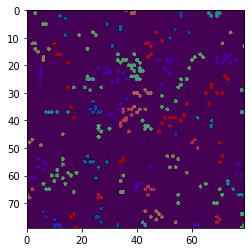

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs90-SNR01_01_07.dat


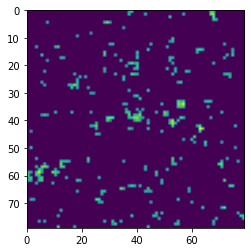

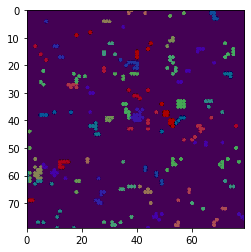

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs95-SNR01_01_07.dat


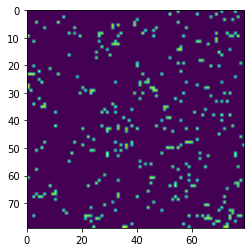

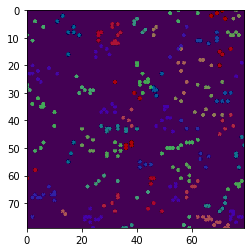

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs85-SNR01_01_08.dat


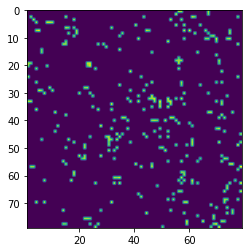

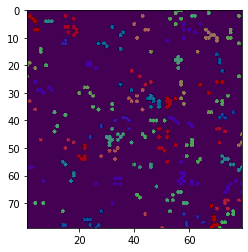

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs90-SNR01_01_08.dat


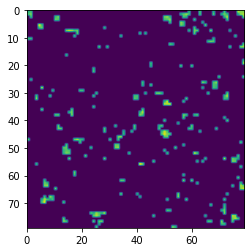

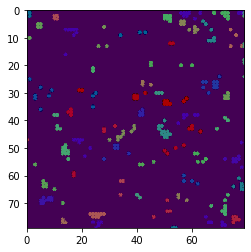

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs95-SNR01_01_08.dat


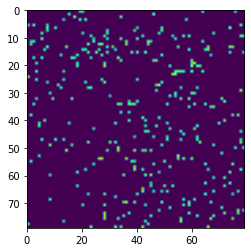

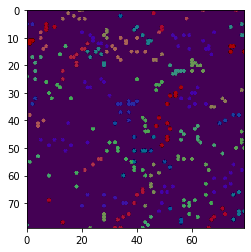

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs85-SNR01_01_09.dat


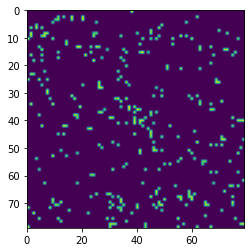

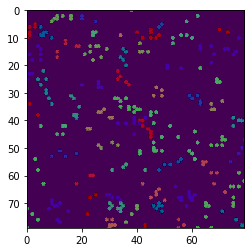

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs90-SNR01_01_09.dat


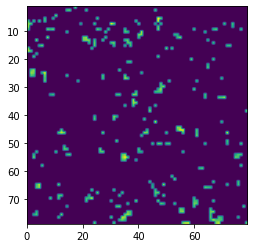

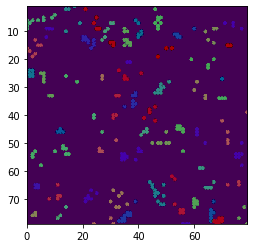

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs95-SNR01_01_09.dat


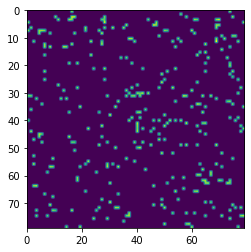

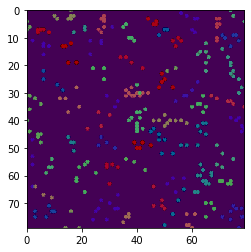

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs85-SNR01_01_10.dat


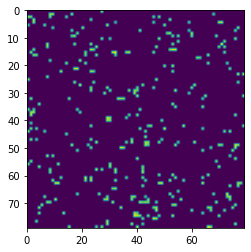

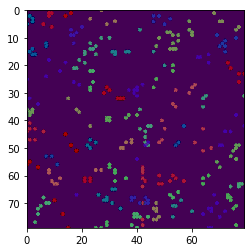

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs90-SNR01_01_10.dat


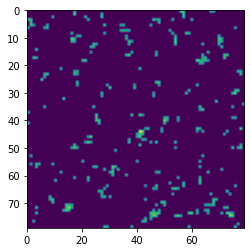

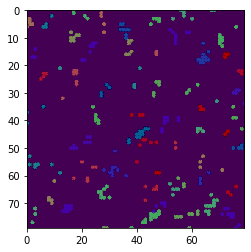

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs95-SNR01_01_10.dat


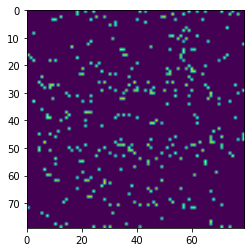

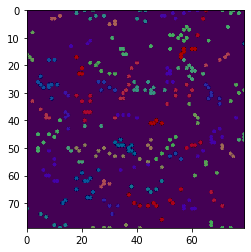

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs85-SNR01_01_11.dat


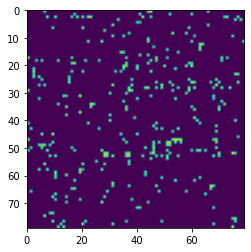

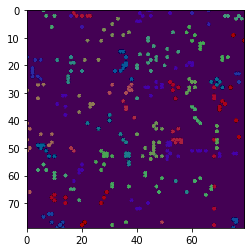

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs90-SNR01_01_11.dat


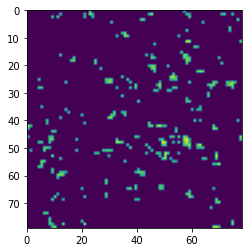

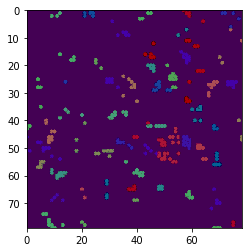

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs95-SNR01_01_11.dat


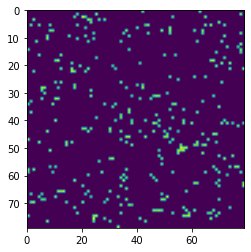

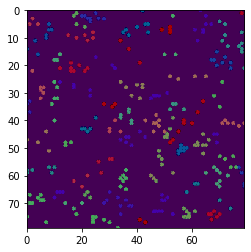

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs85-SNR01_01_12.dat


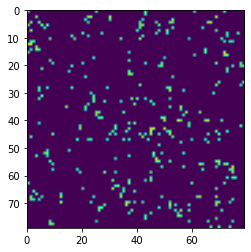

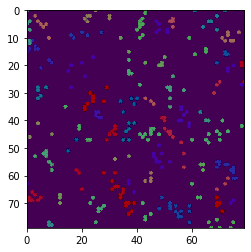

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs90-SNR01_01_12.dat


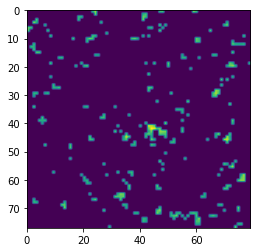

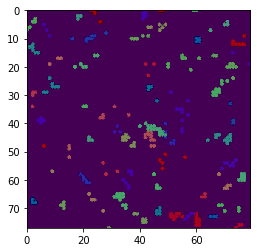

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs95-SNR01_01_12.dat


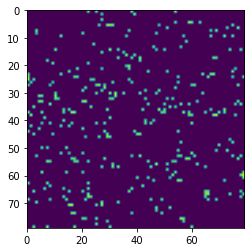

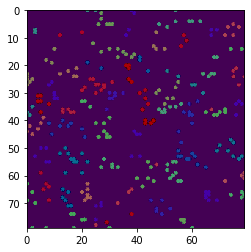

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs85-SNR01_01_13.dat


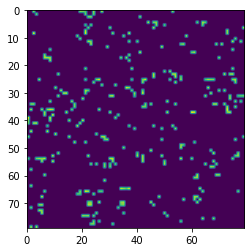

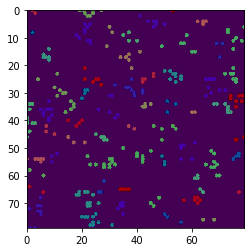

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs90-SNR01_01_13.dat


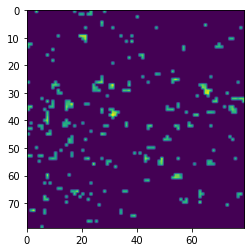

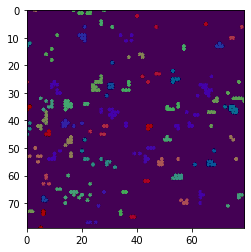

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs95-SNR01_01_13.dat


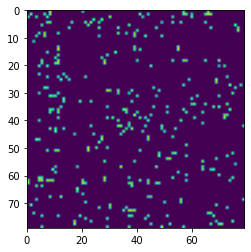

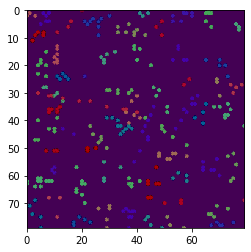

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs85-SNR01_01_14.dat


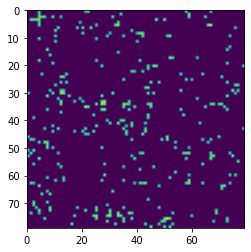

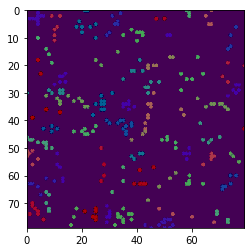

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs90-SNR01_01_14.dat


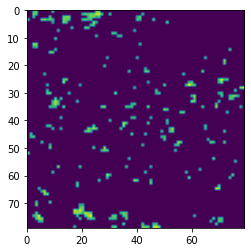

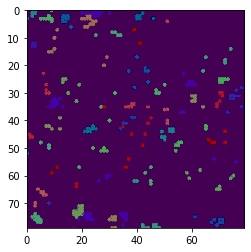

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs95-SNR01_01_14.dat


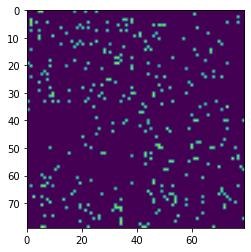

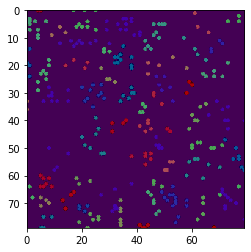

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs85-SNR01_01_15.dat


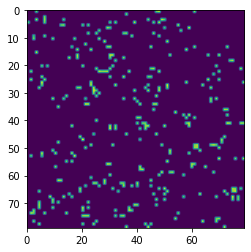

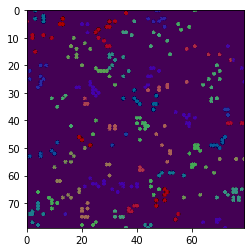

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs90-SNR01_01_15.dat


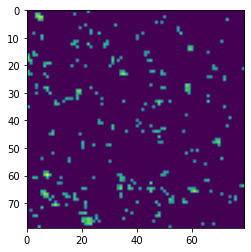

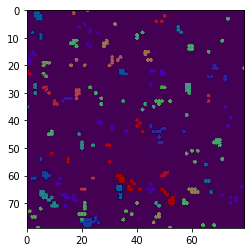

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs95-SNR01_01_15.dat


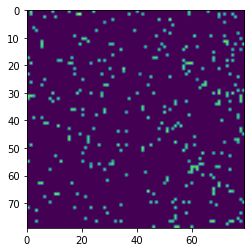

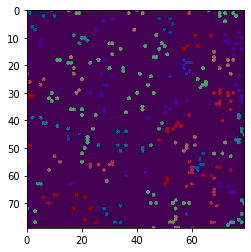

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs85-SNR01_01_16.dat


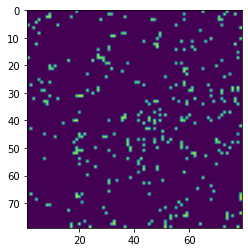

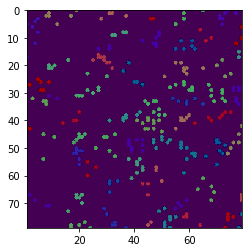

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs90-SNR01_01_16.dat


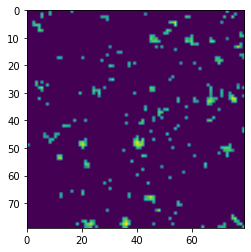

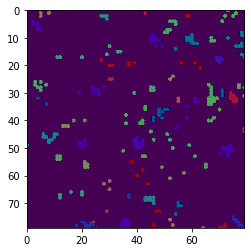

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs95-SNR01_01_16.dat


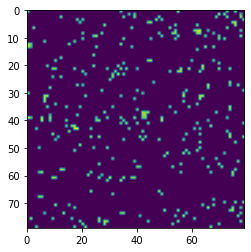

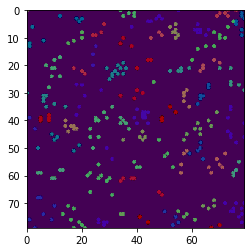

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs85-SNR01_01_17.dat


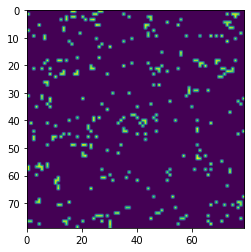

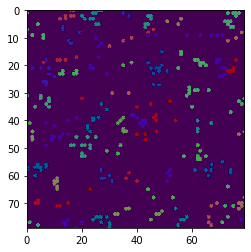

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs90-SNR01_01_17.dat


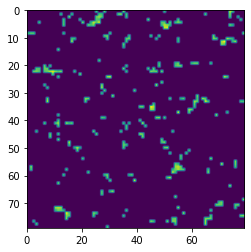

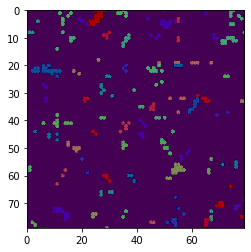

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs95-SNR01_01_17.dat


In [7]:
# single_images structure:
# single_images[slic][loc][image_type] = dic_image 2-D array
#    where image_type is ['e', 'f', 'i'] for electrode, fluorescent, or image
# single_images[slic][loc][map_type][rec] = dat_image 2-D array
#    where map_type is ['Amp', 'SNR', 'Nos'] for amplitude, SNR< or no-stim SNR
# single_images[slic][loc]['stims'] = [stim list indexed by rec #]

percentile_strata = [[80, 85], [85, 90], [90, 95], [95, 100]]
percentile_strata = [[85, 90], [90, 95], [95, 100]]


for slic in single_images:
    for loc in single_images[slic]:
        
        # DICs
        #img = single_images[slic][loc]['i']
        #electrode = single_images[slic][loc]['e']
        #fluor = single_images[slic][loc]['f']
        for rec in single_images[slic][loc]['SNR']:
            
            if process_all or (slic == slice_target and rec in rec_target) and restore_pickle is None::
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                cluster_strata = []

                for stratum in percentile_strata:
                    low_cutoff, hi_cutoff = stratum

                    sampled_points = roi.generate_points(snr, n_points=100000, 
                                                         percentile_cutoff=low_cutoff,
                                                         upper_cutoff=hi_cutoff)

                    roi.heatmap_of_scatter(sampled_points, w, h) # should look similar
                
                    k = k_cluster

                    if k is None:
                        # use AIC and elbow method, then enter choice of k above
                        roi.find_gmm_cluster_number(sampled_points, k_start=30, k_step=10, k_search=91)
                        break
                    else: # after manually selecting k
                        labels = roi.gaussian_mixture_model(sampled_points, k, show=False)

                        roi.draw_gmm_enclosures(sampled_points, labels, a=0.01, s=10)

                        # print ROIs to a DAT file to be loaded into PhotoZ
                        filename = dat_dir + "ROIs" + str(low_cutoff) + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                        roi_write = ROIFileWriter()
                        regions = roi_write.export_clusters(filename, labels, sampled_points, w, limit=num_regions_to_export)
                        all_regions_by_pixel = roi_write.get_regions_by_pixel()
                        # regions is in format of doubly-nested list of PhotoZ diode numbers

                        cluster_objs = []
                        for px_region in all_regions_by_pixel:
                            cluster_objs.append(Cluster(px_region, w))
                            
                        cluster_strata.append(cluster_objs)
                        single_images[slic][loc]['SNR'][rec]['cluster_strata'] = cluster_strata

In [27]:
# save point: pickle all objects to "last run" in current working directory
save_pickle_index = None  # set to int to save pickle
if save_pickle_index is not None and restore_pickle is None:
    pickle_filename = dir_base + date +"/saved_run" + str(i) + ".pickle"
    if os.path.exists(pickle_filename):
        save_pickle_index += 1
        pickle_filename = dir_base + date +"/saved_run" + str(i) + ".pickle"
    with open(pickle_filename, 'rb') as f:
        pickle.dump(single_images, f, pickle.HIGHEST_PROTOCOL)
        print("Wrote:", pickle_filename)

In [ ]:
# restore pickled objects if resuming a run.
if restore_pickle is not None:
    single_images = None
    pickle_filename = dir_base + date +"/saved_run" + str(restore_pickle) + ".pickle"
    if os.path.exists(pickle_filename):
        with open(pickle_filename, 'rb') as f:
            single_images = pickle.load(f)
    else:
        raise FileNotFoundError

In [23]:
for slic in single_images:
    for loc in single_images[slic]:
        for rec in single_images[slic][loc]['SNR']:
            
            if process_all or (slic == slice_target and rec in rec_target):
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                cluster_strata = single_images[slic][loc]['SNR'][rec]['cluster_strata']
                
                print("Strata sizes (# clusters):", [len(stratum) for stratum in cluster_strata])
                
                # Split non-contiguous clusters until contiguous
                for stratum in cluster_strata:
                    extra_clusters = []
                    for cluster in stratum:
                        new_clusters = cluster.attempt_split()
                        extra_clusters += new_clusters
                    stratum += extra_clusters
                
                # Filter clusters by size
                for stratum in cluster_strata:
                    for i in range(len(stratum)-1, -1, -1):  # strata 1 is the lower-SNR strata
                        if stratum[i].get_cluster_size() > n_pixel_cutoff:
                            del stratum[i]
                            
                # Filter clusters by avg SNR
                for stratum in cluster_strata:
                    if len(stratum) > 1:
                        stratum_snrs = np.array([cluster.get_cluster_snr(snr) for cluster in stratum])
                        snr_cutoff = np.percentile(stratum_snrs, average_snr_cutoff_percentile)
                        for i in range(len(stratum_snrs)-1, -1, -1):
                            if stratum_snrs[i] < snr_cutoff:
                                del stratum[i]

                # filter adjacent (touching) clusters of different clusters -- remove the lower-SNR one. 
                for i in range(len(cluster_strata)):
                    stratum1 = cluster_strata[i]
                    for j in range(i+1, len(cluster_strata)):
                        stratum2 = cluster_strata[j]
                        for ic_1 in range(len(stratum1)-1, -1, -1):  # stratum 1 is the lower-SNR stratum
                            for c2 in stratum2:
                                if stratum1[ic_1].is_adjacent_to(c2):
                                    del stratum1[ic_1]
                                    break
                                    
                print("Strata sizes (# clusters):", [len(stratum) for stratum in cluster_strata])


Strata sizes (# clusters): [0, 0, 19]
Strata sizes (# clusters): [0, 0, 12]
Strata sizes (# clusters): [0, 0, 29]
Strata sizes (# clusters): [0, 0, 18]
Strata sizes (# clusters): [0, 0, 30]
Strata sizes (# clusters): [0, 0, 20]
Strata sizes (# clusters): [0, 0, 29]
Strata sizes (# clusters): [0, 0, 20]
Strata sizes (# clusters): [0, 0, 24]
Strata sizes (# clusters): [0, 0, 14]
Strata sizes (# clusters): [0, 0, 23]
Strata sizes (# clusters): [0, 0, 15]
Strata sizes (# clusters): [0, 1, 25]
Strata sizes (# clusters): [0, 1, 16]
Strata sizes (# clusters): [0, 0, 26]
Strata sizes (# clusters): [0, 0, 18]
Strata sizes (# clusters): [0, 0, 22]
Strata sizes (# clusters): [0, 0, 15]
Strata sizes (# clusters): [0, 1, 23]
Strata sizes (# clusters): [0, 1, 16]
Strata sizes (# clusters): [0, 1, 25]
Strata sizes (# clusters): [0, 1, 15]
Strata sizes (# clusters): [0, 1, 24]
Strata sizes (# clusters): [0, 1, 17]
Strata sizes (# clusters): [0, 0, 28]
Strata sizes (# clusters): [0, 0, 19]


Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs-highest-SNR01_01_05.dat


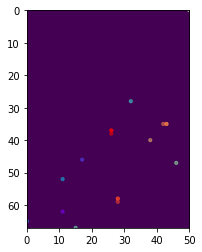

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs-highest-SNR01_01_06.dat


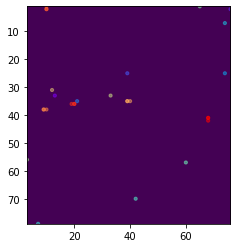

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs-highest-SNR01_01_07.dat


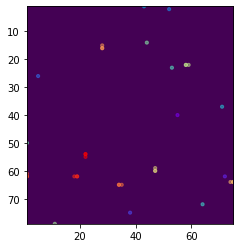

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs-highest-SNR01_01_08.dat


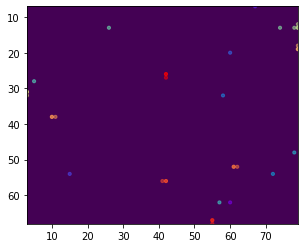

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs-highest-SNR01_01_09.dat


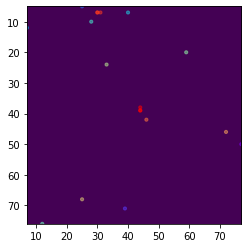

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs-highest-SNR01_01_10.dat


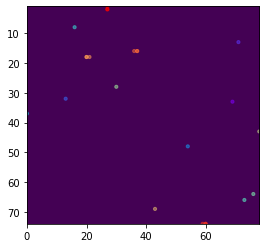

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs-highest-SNR01_01_11.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs-highest-SNR01_01_11.dat


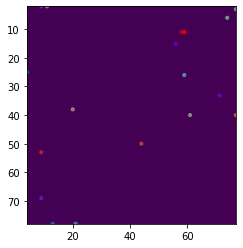

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs-highest-SNR01_01_12.dat


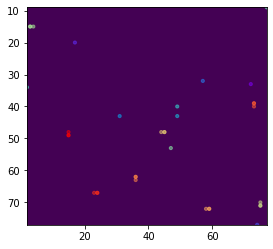

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs-highest-SNR01_01_13.dat


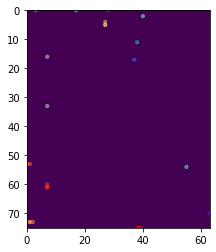

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs-highest-SNR01_01_14.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs-highest-SNR01_01_14.dat


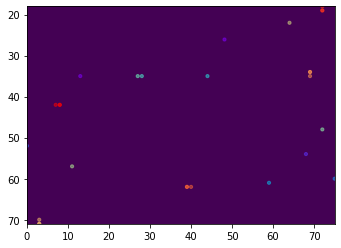

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs-highest-SNR01_01_15.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs-highest-SNR01_01_15.dat


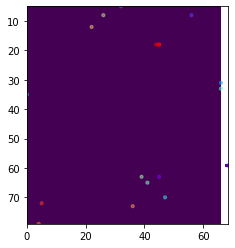

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs-highest-SNR01_01_16.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs-highest-SNR01_01_16.dat


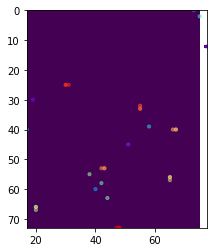

Regions written to: C:/Users/jjudge3/Desktop/Data/07-19-22/converted_zda/ROIs-highest-SNR01_01_17.dat


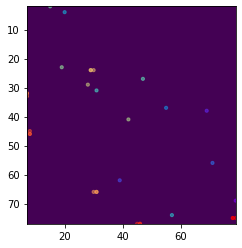

In [24]:
for slic in single_images:
    for loc in single_images[slic]:
        for rec in single_images[slic][loc]['SNR']:
            
            if process_all or (slic == slice_target and rec in rec_target):
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                cluster_strata = single_images[slic][loc]['SNR'][rec]['cluster_strata']
                                                    
                # consolidate strata and show all surviving ROIs
                plt.clf()
                j_label = 0
                for i in range(len(cluster_strata)):
                    stratum = cluster_strata[i]
                    if len(stratum) > 0:
                        pixels = []
                        labels = []
                        for c in stratum:
                            new_pixels = c.get_pixels()
                            pixels += new_pixels
                            labels += [j_label for _ in range(len(new_pixels))]
                            j_label += 1
                        pixels = np.array(pixels)
                        roi.draw_gmm_enclosures(pixels, labels, a=0.5, s=10, show=False, plot_sample_heatmap=False)
                        filename = dat_dir + "ROIs-highest" + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                        roi_write = ROIFileWriter()
                        
                        # export only the highest SNR clusters.
                        regions = roi_write.export_clusters(filename, labels, pixels, w, 
                                                            limit=num_regions_to_export,
                                                            snr=snr)
                plt.show()

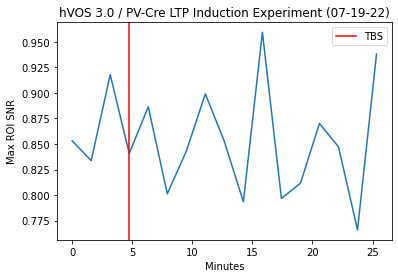

In [25]:
for slic in single_images:
    for loc in single_images[slic]:
        rec_time_course = []
        if process_all or (slic == slice_target and rec in rec_target): 
            for rec in single_images[slic][loc]['SNR']:

                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                cluster_strata = single_images[slic][loc]['SNR'][rec]['cluster_strata']


                time_course_metrics = []

                # find relevant signal statistic for time course
                # avg or max SNR of clusters
                for stratum in cluster_strata:
                    snrs = [c.get_cluster_snr(snr) for c in stratum]  # these are averages
                    if len(snrs) > 0:
                        if time_course_types[time_course_choice] == 'Max':
                            time_course_metrics.append(np.max(snrs))
                        elif time_course_types[time_course_choice] == 'Avg':
                            time_course_metrics.append(np.average(snrs))
                    else:
                        time_course_metrics.append(0)

                # time course
                if time_course_types[time_course_choice] == 'Max':
                    rec_time_course.append(max(time_course_metrics))
                elif time_course_types[time_course_choice] == 'Avg':
                    rec_time_course.append(sum(time_course_metrics) / len(time_course_metrics))

            # time course for all recordings for this slice/loc
            plt.clf()
            times = [i * actual_int_recording / 60 for i in range(len(rec_time_course))]
            plt.plot(times, rec_time_course)
            
            # label TBS time
            i_tbs = rec_target.index(tbs_recording_no)
            t_tbs = times[i_tbs]
            plt.axvline(x = t_tbs, color = 'r', label = 'TBS')
            
            plt.xlabel("Minutes")
            plt.ylabel(time_course_types[time_course_choice] + " ROI SNR")
            plt.title("hVOS 3.0 / PV-Cre LTP Induction Experiment (" + date + ")" )
            plt.legend()
            plt.show()
                

In [12]:
first_recordings_range = [i for i in range(2, tbs_recording_no)]  # 2 is the first recording at 40 uA
last_recordings_range = [i for i in range(tbs_recording_no+int(len(rec_target)/3), rec_target[-1]+1)]

for slic in single_images:
    for loc in single_images[slic]:
        rec_time_course = []
        for rec in single_images[slic][loc]['SNR']:
            if process_all or (slic == slice_target and rec in rec_target):

                # Export ROIs to ImageZ format for region drawing
                pass
            
                # Create post-pre maps for first and last recordings
                pass
                
